In [1]:
# HIDE
%load_ext autoreload
%autoreload 2

In [2]:
# HIDE
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from IPython import display
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


torch.manual_seed(1)
np.random.seed(7)
sns.set(style="white", palette="muted", color_codes=True, context="talk")

%matplotlib inline

/home/arijit/anaconda3/envs/fairDLRM/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_ICU_data(path):
    column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education_num',
                    'martial_status', 'occupation', 'relationship', 'race', 'sex',
                    'capital_gain', 'capital_loss', 'hours_per_week', 'country', 'target']
    input_data = (pd.read_csv(path, names=column_names,
                              na_values="?", sep=r'\s*,\s*', engine='python')
                  .loc[lambda df: df['race'].isin(['White', 'Black'])])
    # sensitive attributes; we identify 'race' and 'sex' as sensitive attributes
    sensitive_attribs = ['race', 'sex']
    Z = (input_data.loc[:, sensitive_attribs]
         .assign(race=lambda df: (df['race'] == 'White').astype(int),
                 sex=lambda df: (df['sex'] == 'Male').astype(int)))

    # targets; 1 when someone makes over 50k , otherwise 0
    y = (input_data['target'] == '>50K').astype(int)

    # features; note that the 'target' and sentive attribute columns are dropped
    X = (input_data
         .drop(columns=['target', 'race', 'sex', 'fnlwgt'])
         .fillna('Unknown')
         .pipe(pd.get_dummies, drop_first=True))

    print(f"features X: {X.shape[0]} samples, {X.shape[1]} attributes")
    print(f"targets y: {y.shape} samples")
    print(f"sensitives Z: {Z.shape[0]} samples, {Z.shape[1]} attributes")
    return X, y, Z


In [4]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

def plot_distributions(y_true, Z_true, y_pred, Z_pred=None, epoch=None):

    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

    subplot_df = (
        Z_true
        .assign(race=lambda x: x['race'].map({1: 'white', 0: 'black'}))
        .assign(sex=lambda x: x['sex'].map({1: 'male', 0: 'female'}))
        .assign(y_pred=y_pred)
    )
    _subplot(subplot_df, 'race', ax=axes[0])
    _subplot(subplot_df, 'sex', ax=axes[1])
    _performance_text(fig, y_true, Z_true, y_pred, Z_pred, epoch)
    fig.tight_layout()
    return fig


def _subplot(subplot_df, col, ax):
    for label, df in subplot_df.groupby(col):
        sns.kdeplot(df['y_pred'], ax=ax, label=label, shade=True)
    ax.set_title(f'Sensitive attribute: {col}')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 7)
    ax.set_yticks([])
    ax.set_ylabel('Prediction distribution')
    ax.set_xlabel(r'$P({{income>50K}}|z_{{{}}})$'.format(col))


def _performance_text(fig, y_test, Z_test, y_pred, Z_pred=None, epoch=None):

    if epoch is not None:
        fig.text(1.0, 0.9, f"Training epoch #{epoch}", fontsize='16')

    clf_roc_auc = metrics.roc_auc_score(y_test, y_pred)
    clf_accuracy = metrics.accuracy_score(y_test, y_pred > 0.5) * 100
    p_rules = {'race': p_rule(y_pred, Z_test['race']),
               'sex': p_rule(y_pred, Z_test['sex']),}
    fig.text(1.0, 0.65, '\n'.join(["Classifier performance:",
                                   f"- ROC AUC: {clf_roc_auc:.2f}",
                                   f"- Accuracy: {clf_accuracy:.1f}"]),
             fontsize='16')
    fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                 [f"- {attr}: {p_rules[attr]:.0f}%-rule"
                                  for attr in p_rules.keys()]),
             fontsize='16')
    if Z_pred is not None:
        adv_roc_auc = metrics.roc_auc_score(Z_test, Z_pred)
        fig.text(1.0, 0.20, '\n'.join(["Adversary performance:",
                                       f"- ROC AUC: {adv_roc_auc:.2f}"]),
                 fontsize='16')

In [7]:
# HIDE

# load ICU data set
X, y, Z = load_ICU_data('/home/arijit/PycharmProjects/fairDLRM/data/adult.data')

numerical_cols = ['age', 'education_num', 'capital_gain', 'capital_loss',
                   'hours_per_week']
categorical_cols = X.columns.difference(numerical_cols + ['relationship_Wife'] + X.columns[X.sum() < 100].tolist()
                                        + X.columns[X.columns.str.startswith('relationship')].tolist() +
                                         X.columns[X.columns.str.startswith('martial')].tolist())

X_num = X.loc[:, numerical_cols]
X_cat = X.loc[:, categorical_cols]
n_features = X.shape[1]
n_num_features = X_num.shape[1]
n_cat_features = X_cat.shape[1]
n_features = n_num_features + n_cat_features
n_sensitive = Z.shape[1]

# # split into train/test set
(X_train, X_test, y_train, y_test,
 Z_train, Z_test, X_num_train, X_num_test,
 X_cat_train, X_cat_test) = train_test_split(X, y, Z, X_num, X_cat, test_size=0.5,
                                     stratify=y, random_state=7)

# # standardize the data
scaler = StandardScaler().fit(X_num_train)
scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df), 
                                           columns=df.columns, index=df.index)
X_num_train = X_num_train.pipe(scale_df, scaler) 
X_num_test = X_num_test.pipe(scale_df, scaler) 

X_train = pd.concat([X_num_train, X_cat_train], axis=1)
X_test = pd.concat([X_num_test, X_cat_test], axis=1)

features X: 30940 samples, 93 attributes
targets y: (30940,) samples
sensitives Z: 30940 samples, 2 attributes


In [8]:
class PandasDataSet(TensorDataset):

    def __init__(self, *dataframes):
        tensors = (self._df_to_tensor(df) for df in dataframes)
        super(PandasDataSet, self).__init__(*tensors)

    def _df_to_tensor(self, df):
        if isinstance(df, pd.Series):
            df = df.to_frame('dummy')
        return torch.from_numpy(df.values).float()


train_data = PandasDataSet(X_train, y_train, Z_train, X_num_train, X_cat_train)
test_data = PandasDataSet(X_test, y_test, Z_test, X_num_train, X_cat_train)

In [9]:
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, drop_last=True)

print('# training samples:', len(train_data))
print('# batches:', len(train_loader))

# training samples: 15470
# batches: 483


In [10]:
class PreNumerical(nn.Module):

    def __init__(self, n_features, n_sensitive, n_hidden=32, p_dropout=0.2):
        super(PreNumerical, self).__init__()
        self.network = nn.Sequential(
#             nn.Linear(n_sensitive, n_features),  # DELETE
            nn.Linear(n_sensitive, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_features),
        )

    def forward(self, x):
        return self.network(x)
    
    
class PreCategorical(nn.Module):

    def __init__(self, n_features, n_sensitive, n_hidden=32, p_dropout=0.2):
        super(PreCategorical, self).__init__()
        self.network = nn.Sequential(
#             nn.Linear(n_sensitive, n_features),  # DELETE
            nn.Linear(n_sensitive, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
            nn.Linear(n_hidden, n_features),
#             nn.ReLU(),
#             nn.Dropout(p_dropout),
        )

    def forward(self, x):
        return F.sigmoid(self.network(x))

In [11]:
num = PreNumerical(n_features=n_num_features, n_sensitive=Z.shape[1])
num_criterion = nn.MSELoss()
num_optimizer = optim.Adam(num.parameters(), amsgrad=True)

cat = PreCategorical(n_features=n_cat_features, n_sensitive=Z.shape[1])
cat_criterion = nn.BCELoss()
cat_optimizer = optim.Adam(cat.parameters(), amsgrad=True)

In [12]:
for epoch in range(10):
    for _, _, z, x_num, x_cat in train_loader:
        num.zero_grad()
        x_num_pred = num(z)
        num_loss = num_criterion(x_num_pred, x_num)
        num_loss.backward()
        num_optimizer.step()
        
        cat.zero_grad()
        x_cat_pred = cat(z)
        cat_loss = cat_criterion(x_cat_pred, x_cat)
        cat_loss.backward()
        cat_optimizer.step()        
        
    with torch.no_grad():
        x_num_pred = num(test_data.tensors[2])
        num_loss = num_criterion(x_num_pred, test_data.tensors[3])
        x_cat_pred = cat(test_data.tensors[2])
        cat_loss = cat_criterion(x_cat_pred, test_data.tensors[4])
    print(epoch, 'num', num_loss, 'cat', cat_loss)

/home/arijit/anaconda3/envs/fairDLRM/lib/python3.9/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0 num tensor(1.0138) cat tensor(0.2122)
1 num tensor(1.0118) cat tensor(0.2119)
2 num tensor(1.0161) cat tensor(0.2116)
3 num tensor(1.0171) cat tensor(0.2115)
4 num tensor(1.0134) cat tensor(0.2109)
5 num tensor(1.0132) cat tensor(0.2110)
6 num tensor(1.0155) cat tensor(0.2107)
7 num tensor(1.0147) cat tensor(0.2102)
8 num tensor(1.0111) cat tensor(0.2104)
9 num tensor(1.0134) cat tensor(0.2103)


In [13]:
ii = 1

pred = x_cat_pred.numpy()[:, ii]
true = test_data.tensors[4].numpy()[:, ii]

In [14]:
# (Z_train.loc[X_train['martial_status_Married-civ-spouse'] == 1, 'sex'] == 0).all()

In [15]:
X_train.corrwith(Z_train['sex']).sort_values()

occupation_Other-service       -0.160142
occupation_Priv-house-serv     -0.081233
education_Some-college         -0.065534
workclass_Unknown              -0.062125
occupation_Unknown             -0.061436
workclass_Private              -0.039097
workclass_Local-gov            -0.032544
education_Assoc-acdm           -0.031715
occupation_Prof-specialty      -0.031587
workclass_State-gov            -0.020244
education_Assoc-voc            -0.019281
occupation_Sales               -0.018568
occupation_Tech-support        -0.018406
education_11th                 -0.017607
education_12th                 -0.004725
country_United-States          -0.003851
country_Germany                -0.003828
country_Canada                  0.003777
education_Masters               0.008812
country_El-Salvador             0.008867
education_num                   0.012176
education_HS-grad               0.013186
education_1st-4th               0.015362
country_Unknown                 0.019359
education_7th-8t

In [16]:
np.unique(pred)

array([0.00023233, 0.00025676, 0.00025859, ..., 0.03359749, 0.03534519,
       0.03546967], dtype=float32)

<AxesSubplot:ylabel='Density'>

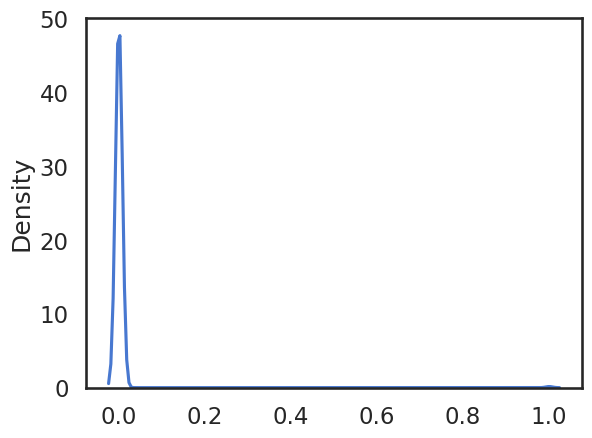

In [17]:
sns.kdeplot(true)

/home/arijit/anaconda3/envs/fairDLRM/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


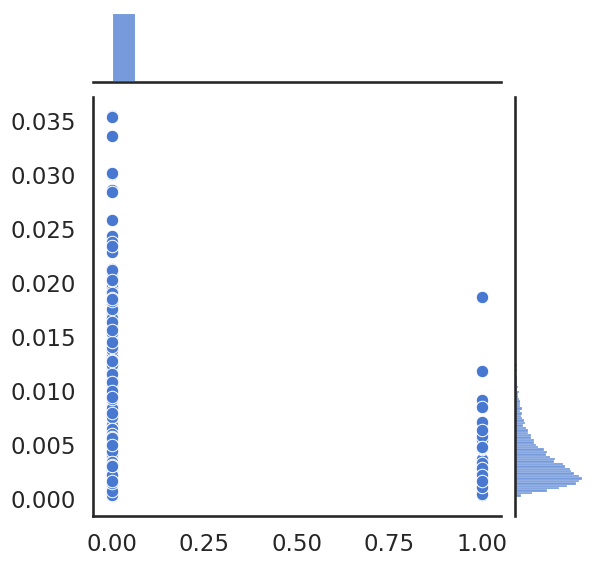

In [18]:
sns.jointplot(true, pred)

In [43]:
class Classifier(nn.Module):

    def __init__(self, n_features, n_hidden=32, p_dropout=0.2):
        super(Classifier, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(n_features, n_hidden),
            nn.ReLU(),
            nn.Dropout(p_dropout),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(p_dropout),
#             nn.Linear(n_hidden, n_hidden),
#             nn.ReLU(),
#             nn.Dropout(p_dropout),
            nn.Linear(n_hidden, 1),
        )

    def forward(self, x):
        return F.sigmoid(self.network(x))

In [44]:
clf = Classifier(n_features=n_features)
clf_criterion = nn.BCELoss()
clf_optimizer = optim.Adam(clf.parameters(), amsgrad=True)

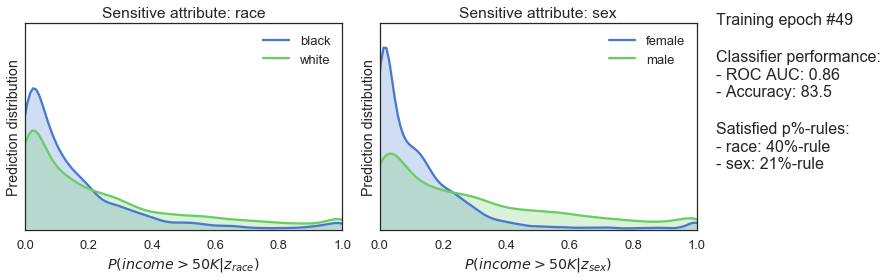

49 tensor(0.3734) tensor(1.0148) tensor(0.2100)


In [45]:
for epoch in range(50):
    for x, y, z, x_num, x_cat in train_loader:
        
        num.zero_grad()
        x_num_pred = num(z)
        num_loss = num_criterion(x_num_pred, x_num)
        num_loss.backward()
        num_optimizer.step()
        
        cat.zero_grad()
        x_cat_pred = cat(z)
        cat_loss = cat_criterion(x_cat_pred, x_cat)
        cat_loss.backward()
        cat_optimizer.step()    
        
        x_pred = torch.cat((num(z), cat(z)), dim=1).detach()
        
        clf.zero_grad()
        epsilon = x - x_pred
        y_pred = clf(epsilon)
        clf_loss = clf_criterion(y_pred, y)
        clf_loss.backward()
        clf_optimizer.step()  

    with torch.no_grad():
        x_num_pred = num(test_data.tensors[2])
        num_loss = num_criterion(x_num_pred, test_data.tensors[3])
        x_cat_pred = cat(test_data.tensors[2])
        cat_loss = cat_criterion(x_cat_pred, test_data.tensors[4])
        x_pred = torch.cat((x_num_pred, x_cat_pred), dim=1)
        epsilon = test_data.tensors[0] - x_pred
        y_pred = clf(epsilon)
        clf_loss = clf_criterion(y_pred, test_data.tensors[1])
    
    print(epoch, clf_loss, num_loss, cat_loss)    
    test = (
        pd.DataFrame(y_pred.numpy(), columns=['pred'], index=y_test.index)
            .assign(true=y_test)
    )
    plot_distributions(y_test, Z_test, test['pred'], epoch=epoch)
    display.clear_output(wait=True)
    plt.show(plt.gcf())
    print(epoch, clf_loss, num_loss, cat_loss)    

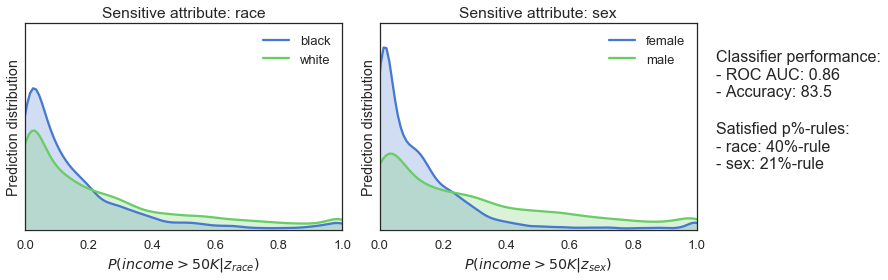

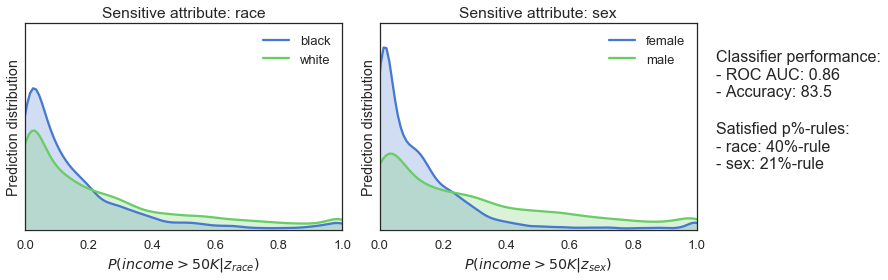

In [46]:
test = (
    pd.DataFrame(y_pred.numpy(), columns=['pred'], index=y_test.index)
    .assign(true=y_test)
)

plot_distributions(y_test, Z_test, test['pred'])

In [20]:

for x, y, z in train_loader:
    pass
    

ValueError: too many values to unpack (expected 3)